# Reservoir Computing

Reservoir computing is a computational framework for training recurrent neural networks efficiently. It separates the dynamic processing of inputs (handled by a fixed recurrent network — the "reservoir") from the learning mechanism (handled by a simple linear readout layer).

##  Learning Objectives
- Recap of RC
- Hyperparameter
- Implement a simple ESN for a sine wave prediction
- 


## 🔁 1. Motivation: Recurrent Neural Networks (RNNs)

RNNs are powerful models for temporal and sequential data but are notoriously difficult to train because of:
- **Vanishing/exploding gradients**
- **High computational cost**
- **Instability with long sequences**

Reservoir computing offers a way to leverage the dynamic power of RNNs while avoiding backpropagation through time.



<div style="text-align:center">
    <img src="ResSchemetics.png" alt="Perceptron Diagram" style="width:600px">
</div>

## 2. Echo State Networks (ESNs)

An ESN consists of:
- **Input weights** $\mathbf{W}_{in} $
- **Reservoir (recurrent) weights** $\mathbf{W}_{res}$
- **Readout weights** $\mathbf{W}_{out}$

### State Update Equation
$$
\mathbf{x}(t+1) = \tanh(\mathbf{W}_{res} \mathbf{x}(t) + \mathbf{W}_{in} \mathbf{u}(t))
$$

### Output Equation
$$
\mathbf{y}(t) = \mathbf{W}_{out} \mathbf{x}(t)
$$

> Note: Only $\mathbf{W}_{out}$ is trained using ridge regression or linear regression.


### Training of Readout - Ridge Regression

Common way to train a linear feed forward network is to use Ridge Regression. To train $W^{out}$,
$$
W^{out} = Y^{target} X^T (XX^T + \beta I)^{-1}
$$
This is a closed form solution. This just adjusts the output weights that solves the equation. Beta here is a regularization constant. 

### Important difference

- Closed formed solution
- No epochs - One shot adjustment of the weights
- Only trains output layer, $W^{out}$
- Enjoys universal approximation theorem

### Hyper parameters

The global parameters of the Reservoir are, Size of Reservoir $N_{x}$, sparsity, Distribution of the non zero elements, Spectral Radius of W, Scaling of $W^{in}$, and leaking rate $\alpha$. 

- **Size of the Reservoir :** Choose the reservoir to be as big as computationally possible. Common tasks will leave the reservoir of the size, $10^4$. Optimize the parameters with smaller reservoir and then scale it to bigger reservoir. For i.i.d (Independent identically distributed) tasks, the size should be of $N_{u}$ if the input is of size $u$. But for time dependent tasks it will compress significantly. 

- **Sparsity :** Sparsity is a low priority parameter. It refers to the elements in $W^{in}$ equals to zero. It helps with the computational speed ups of the reservoir. This is called **fan-out** number, The number of the neurons connected to other neurons.

...Others as we go on

### Practical approch


For ESNs there are three main parameter:
1. Input Scaling
2. Spectral Radius
3. Leaky Rate

Reservoir size is generally an external restriction. For most of chaotic series (ex. Lorenz) size of 1000 serves well, but after that the returns are diminishing.

## 3. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [2]:
# 🧠 4. Reservoir Initialization
def generate_reservoir(N, sparsity=0.1, spectral_radius=0.9):
    W = np.random.randn(N, N)
    mask = np.random.rand(N, N) < sparsity
    W *= mask
    eigvals = np.linalg.eigvals(W)
    W *= spectral_radius / np.max(np.abs(eigvals))
    return W

## 5. Echo State Network (ESN)

In [3]:

class ESN:
    def __init__(self, n_input, n_reservoir, n_output, spectral_radius=0.9, sparsity=0.1, ridge_alpha=1e-6):
        self.n_reservoir = n_reservoir
        self.Win = np.random.uniform(-1, 1, (n_reservoir, n_input))
        self.Wres = generate_reservoir(n_reservoir, sparsity, spectral_radius)
        self.Wout = None
        self.ridge_alpha = ridge_alpha
        self.state = np.zeros(n_reservoir)

    def _update(self, u):
        self.state = np.tanh(self.Wres @ self.state + self.Win @ u)
        return self.state

    def fit(self, U, Y):
        states = np.vstack([self._update(u) for u in U])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(states, Y)
        self.Wout = reg.coef_

    def predict(self, U):
        preds = []
        for u in U:
            x = self._update(u)
            y = self.Wout @ x
            preds.append(y)
        return np.array(preds)

## 6. Example: Predicting a Sine Wave

In [4]:
timesteps = 500
t = np.linspace(0, 20 * np.pi, timesteps)
signal = np.sin(t).reshape(-1, 1)

train_len = 300
test_len = 200

train_input = signal[:train_len]
test_input = signal[train_len-1:-1]
train_output = signal[1:train_len+1]
test_output = signal[train_len:]

In [5]:
# 🧪 7. Train and Test the ESN
esn = ESN(n_input=1, n_reservoir=100, n_output=1, spectral_radius=0.95)
esn.fit(train_input, train_output)
predicted = esn.predict(test_input)

## 7. Visualize Results

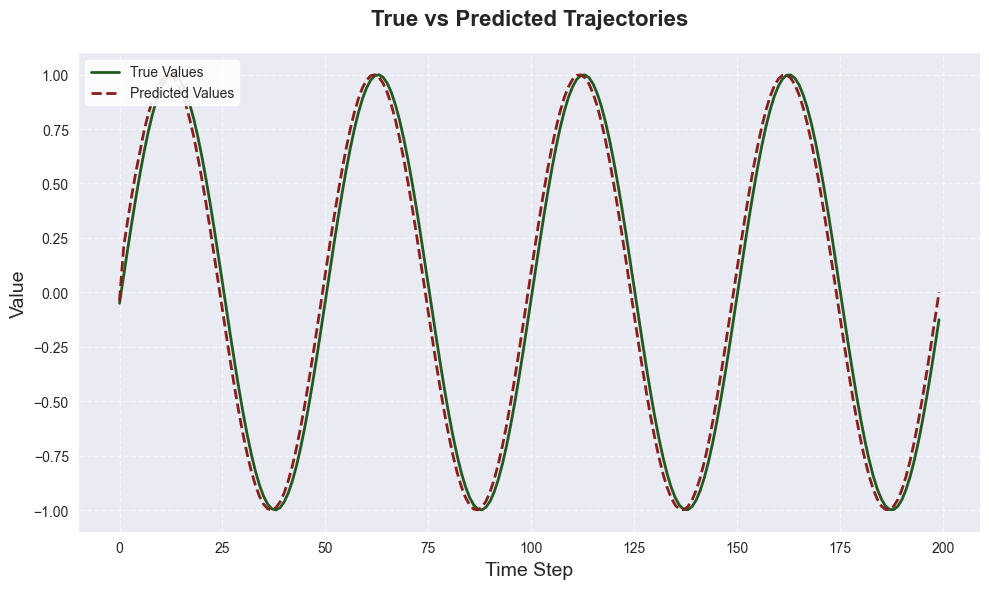

In [6]:
from helper_functions import plot_trajectories

plt = plot_trajectories(test_input, predicted)
plt.show()

## 8. Chaotic Timeseries

In [7]:
from dysts.flows import Lorenz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import torch

In [8]:
length = 10000
Dataset = Lorenz().make_trajectory(length, method='RK45')

c:\Users\jaych\Lecture\venv\Lib\site-packages\scipy\integrate\_ivp\ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


**Always normalize the input signal.** Normalizing avoids the outliers that can throw the reservoir out of usual trajectory of the input.

In [37]:
from helper_functions import normalize_data

Dataset = normalize_data(Dataset) # Normalization

In [10]:
from viz import compare_plot, plot_components

compare_plot([Dataset], titles= ["Lorenz"])

In [11]:
plot_components(Dataset, title= "Lorenz")

### Hyper parameters and Reservoir states

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import nrmse, rsquare

In [13]:
UNITS = 100               # - number of neurons
LEAK_RATE = 0.3           # - leaking rate
SPECTRAL_RADIUS = 1.25    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproducibility
INPUT_DIM = 3

#### Spectral radius

The *spectral radius* is the **maximum absolute eigenvalue of the reservoir matrix $W$**

**Spectral Radius** is the maximal absolute eigenvalue of the weight matrix $W$. a random sparse $W$ is generated; its spectral radius $ρ(W)$ is computed; then $W$ is divided by $ρ(W)$ to yield a matrix with a unit spectral radius. Then that can be tuned with the tuning procedure.
- The echo state property of the reservoir which is: The state of the reservoir $X(n)$ is uniquely defined by the fading history of the input $u(n)$. 
- Echo state property holds for $\rho(W) < 1$ but practically it can work even with significantly high values of $\rho(W)$. Practically $\rho(W)$ should be selected based on the performance of the network.
-  **The spectral Radius should be greater in tasks requiring longer memory of the input.**

In [14]:
states = []
spectral_radii = [0.1, 1.25, 10.0]
for spectral_radius in spectral_radii:
    reservoir = Reservoir(
        units=UNITS, 
        sr=spectral_radius, 
        input_scaling=INPUT_SCALING, 
        lr=LEAK_RATE, 
        rc_connectivity=RC_CONNECTIVITY,
        input_connectivity=INPUT_CONNECTIVITY,
        seed=SEED,
        input_dim=INPUT_DIM
    )

    s = reservoir.run(Dataset[:500])
    states.append(s)

Running Reservoir-2: 100%|██████████| 500/500 [00:00<00:00, 26317.04it/s]


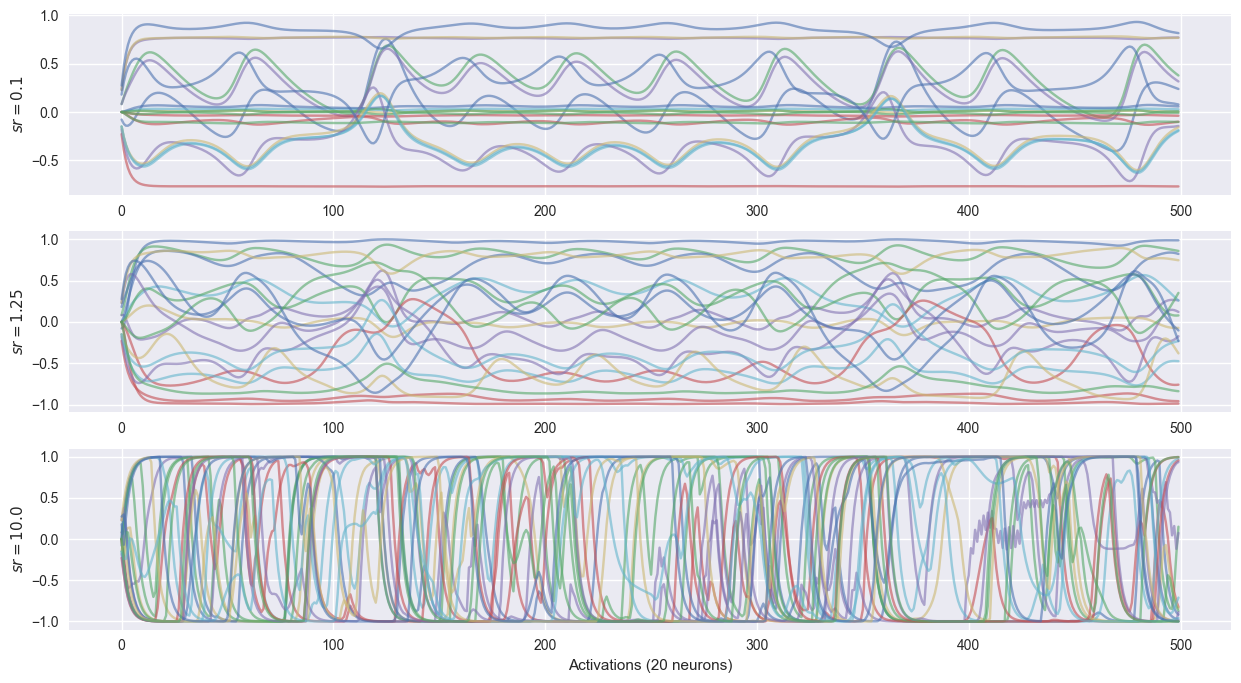

In [15]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(spectral_radii), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$sr={spectral_radii[i]}$")
plt.xlabel(f"Activations ({UNITS_SHOWN} neurons)")
plt.show()

- $-$ spectral radius $\rightarrow$ **stable** dynamics

- $+$ spectral radius $\rightarrow$ **chaotic** dynamics

Spectral radius and *Echo State Property*: a spectral radius close to 1 is supposed, **under certain theoretical assumptions only**, to allow the reservoir states to be less affected by their initial conditions, while having good memorization properties. **In practice, a random search algorithm is the most robust way to find the optimal spectral radius for a precise task.**

#### Input scaling

The input scaling is a **coefficient applied on $W_{in}$** and adding a gain to the inputs of the reservoir.
**Input scaling** `a` is a range of interval [-1;1] from which the $W^{in}$ is sampled. 
- for **linear tasks,** $W^{in}$ should be small(close to 0). Where the tanh() activation is somewhat linear as well. while bigger $W^{in}$(bigger `a`) will have neurons quickly saturating to -1 or 1. 

In [16]:
states = []
input_scalings = [0.1, 1.0, 10.]
for input_scaling in input_scalings:
    reservoir = Reservoir(
        units=UNITS, 
        sr=SPECTRAL_RADIUS, 
        input_scaling=input_scaling, 
        lr=LEAK_RATE,
        rc_connectivity=RC_CONNECTIVITY, 
        input_connectivity=INPUT_CONNECTIVITY, 
        seed=SEED,
        input_dim= INPUT_DIM
    )

    s = reservoir.run(Dataset[:500])
    states.append(s)

Running Reservoir-5: 100%|██████████| 500/500 [00:00<00:00, 28566.88it/s]


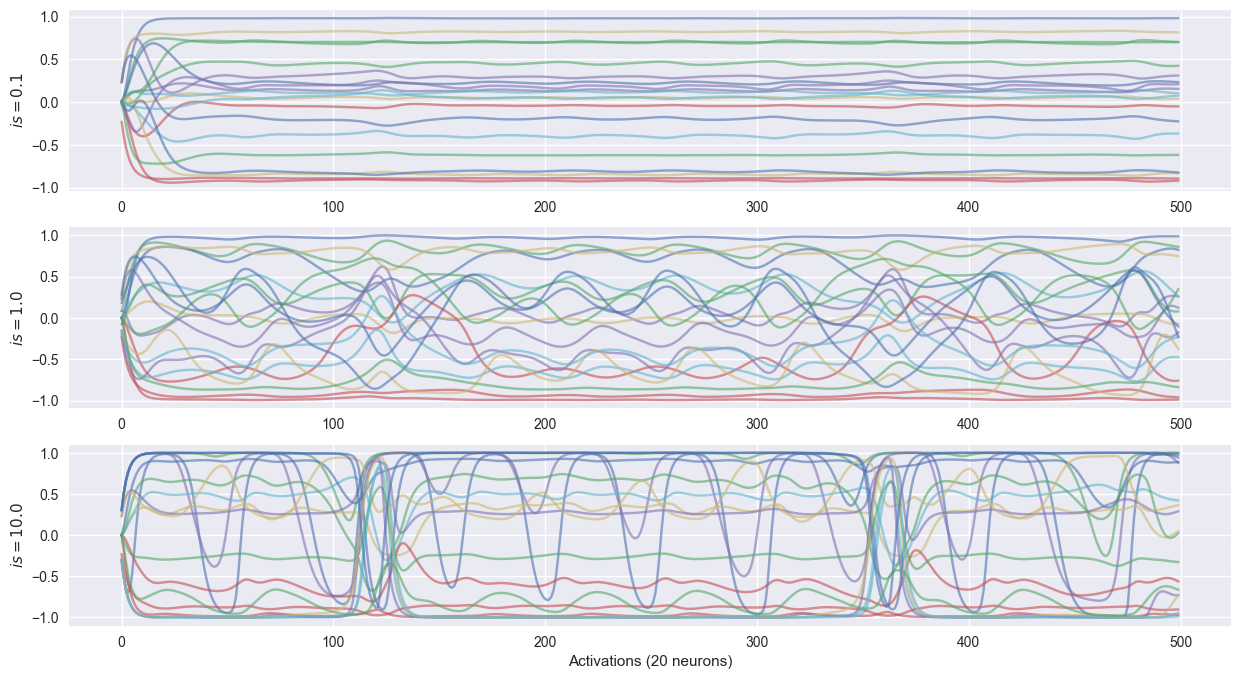

In [17]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(input_scalings), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$is={input_scalings[i]}$")
plt.xlabel(f"Activations ({UNITS_SHOWN} neurons)")
plt.show()

- $+$ input scaling $\rightarrow$ **high states *vs* inputs correlation** (until saturation)
- $-$ input scaling $\rightarrow$ **free running states**

The *input scaling* can also be used to adjust the influence of each variable in a multivariates timeseries.

#### Leaking rate


$$
x(t+1) =  {\color{red}(1 - \alpha)} \underbrace{x(t)}_{\text{current}} + {\color{red}\alpha} \underbrace{f(u(t+1), x(t))}_{\text{new inputs}}
$$

with $\alpha \in [0, 1]$ and:

$$ f(u, x) = \tanh(W_{in} \cdotp u + W \cdotp x) $$


**Leaky Rate** is speed of reservoir update dynamics discretized in time. The paper mentions that it is empirically similar to resampling from $\mathbf{u}(n)$. but it is unclear to me how and why. General guide line is to match the speed of the dynamics. That is to set the leaky rate high for fast changing signal, and low for steady and periodic signals.

In [18]:
states = []
leaking_rates = [0.02, 0.3, 1.0]
for leaking_rate in leaking_rates:
    reservoir = Reservoir(
        units=UNITS, 
        sr=SPECTRAL_RADIUS, 
        input_scaling=INPUT_SCALING, 
        lr=leaking_rate,
        rc_connectivity=RC_CONNECTIVITY, 
        input_connectivity=INPUT_CONNECTIVITY, 
        seed=SEED,
        input_dim=INPUT_DIM
    )

    s = reservoir.run(Dataset[:500])
    states.append(s)

Running Reservoir-8: 100%|██████████| 500/500 [00:00<00:00, 38463.62it/s]


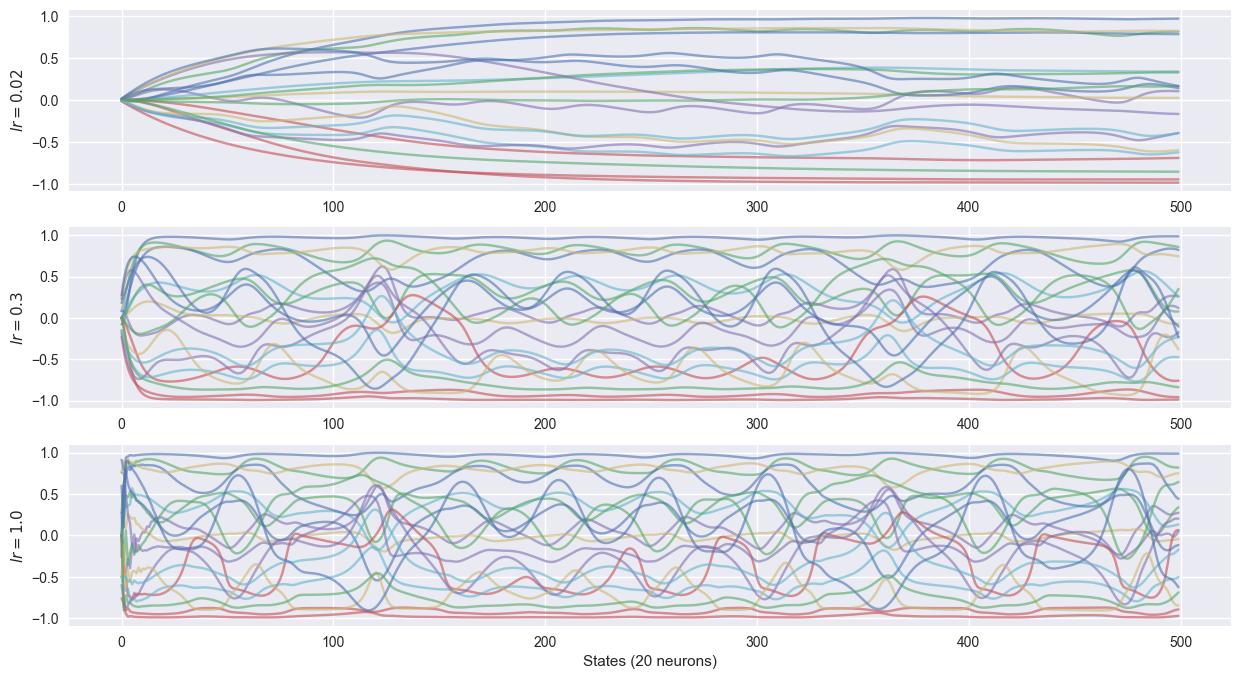

In [19]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(leaking_rates), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$lr={leaking_rates[i]}$")
plt.xlabel(f"States ({UNITS_SHOWN} neurons)")
plt.show()

- $+$ leaking rate $\rightarrow$ **low inertia**, low recall of previous states
- $-$ leaking rate $\rightarrow$ **high inertia**, high recall of previous states

The *leaking rate* controls the time constant of the ESN.

### Training

This is a function to plot some data: 

In [20]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

In [21]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    #plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

#### Splitting of data

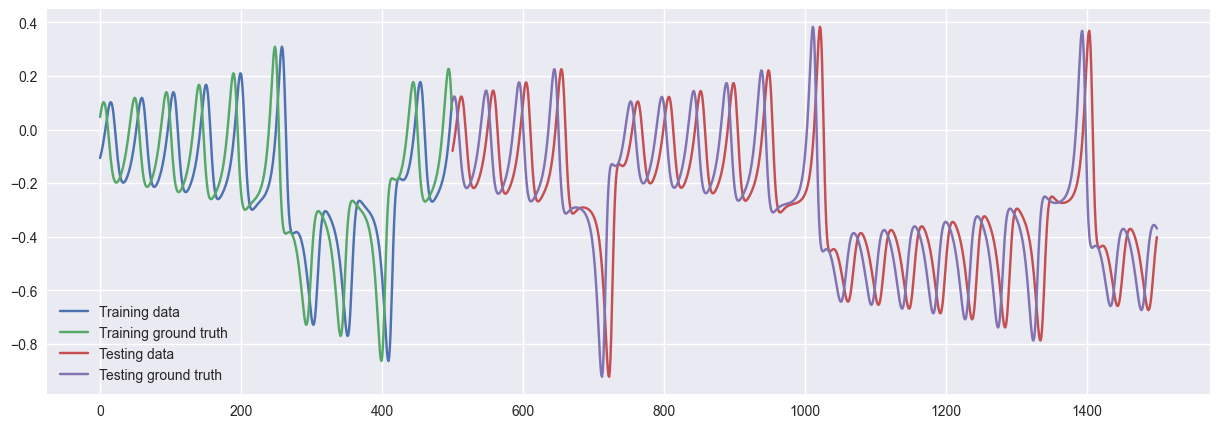

In [22]:
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(Dataset, forecast=10)
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

plot_train_test(X_train1[:1000,1], y_train1[:1000,1], X_test1[:1000,1], y_test1[:1000,1])

#### Setting Hyper Parameters

In [33]:
units = 1000
leak_rate = 0.3
spectral_radius = 1
input_scaling = 1
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

#### Generating Reservoir and Predictions on the Datasets

In [34]:
reservoir = Reservoir(units, input_dim=3, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(3, ridge=regularization)

esn = reservoir >> readout

esn = esn.fit(X_train1, y_train1)
y_pred1 = esn.run(X_test1)
print(f"NRMSE: {nrmse(y_test1, y_pred1)}")

Running Model-2: 2000it [00:00, 9434.81it/s]<?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Fitting node Ridge-2...


Running Model-2: 7990it [00:00, 10458.09it/s]         

NRMSE: 0.017689671283522564


#### Visualizing Results  

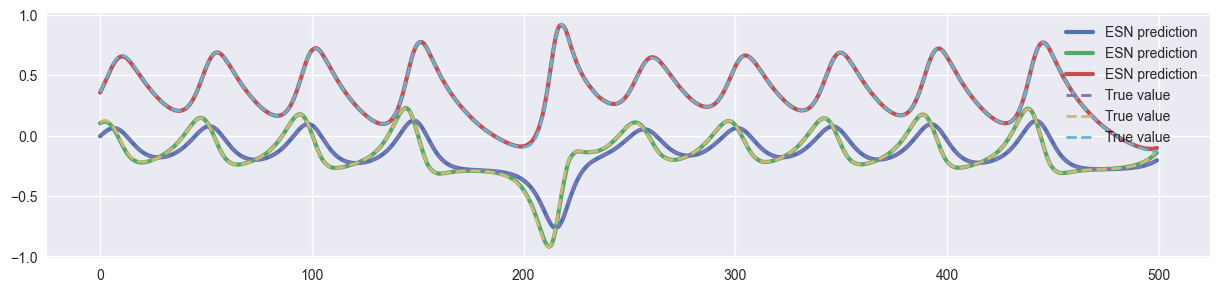

In [35]:
plot_results(y_pred1, y_test1, sample=500)

In [39]:
compare_plot([y_test1, y_pred1], titles=[ "True","Predicted"])

### Why Chaos is hard to "predict"

[How chaotic is chaos? How some AI for Science / SciML papers are overstating accuracy claims](https://www.stochasticlifestyle.com/how-chaotic-is-chaos-how-some-ai-for-science-sciml-papers-are-overstating-accuracy-claims/ "Permanent Link to How chaotic is chaos? How some AI for Science / SciML papers are overstating accuracy claims")

## ✅ 9. Summary

- ESNs simplify RNN training by keeping the reservoir fixed and only learning the output weights
- Some parameters influences learning more then others
- Chaos is hard to predict for longer times
- What reservoir is learning are some mathematical properties properties not the exact trajectories.
- For attractor reproduction NRMSE does not paint the whole picture. 

## 📚 References
- H. Jaeger (2001). *The "Echo State" Approach to Analyzing and Training Recurrent Neural Networks*.
- M. Lukosevicius and H. Jaeger (2009). *Reservoir computing approaches to recurrent neural network training*.
- Mantas Lukoševičius (2012). *A Practical Guide to Applying Echo State Networks*

